# Problema 3 - Clasificación con distintas arquitecturas de red.

In [ ]:
# Tamaño de las imágenes
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
EPOCHS = 20
num_clases = 6

In [ ]:
from google.colab import drive


In [ ]:
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile
import os

# Ruta del archivo ZIP
zip_file_path = '/content/drive/MyDrive/AA2/TP1-3-natural-scenes.zip'
# Ruta donde se extraerán los archivos
extract_to = 'Dataset/'

# Crear la carpeta de extracción si no existe
os.makedirs(extract_to, exist_ok=True)

# Descomprimir el archivo ZIP
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f'Archivos extraídos en: {extract_to}')


Archivos extraídos en: Dataset/


Importar librerías

In [ ]:
import numpy as np
from pathlib import Path
import tensorflow as tf
from keras.layers import Input, Concatenate, Flatten, BatchNormalization, Add, Activation, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers import Dense, Conv2D, MaxPooling2D, Rescaling, RandomFlip, RandomTranslation, RandomContrast, Dropout
import matplotlib.pyplot as plt
from PIL import Image
import random
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.callbacks import EarlyStopping

### Dataset

In [ ]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
# Directorio de los datos
TRAIN_DATA_DIRECTORY = Path("Dataset/seg_train/seg_train")
VALIDATION_DATA_DIRECTORY = Path("Dataset/seg_test/seg_test")
PRED_DATA_DIRECTORY = Path("Dataset/seg_pred/seg_pred")

# Tamaño del lote (batch size)
BATCH_SIZE = 120


# Carga los datos de entrenamiento y validación
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DATA_DIRECTORY,
    label_mode="categorical",
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VALIDATION_DATA_DIRECTORY,
    label_mode="categorical",
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)


Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [ ]:
# Obtiene los nombres de las clases
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [ ]:
#train_ds = train_ds.take(200)
#val_ds = val_ds.take(100)

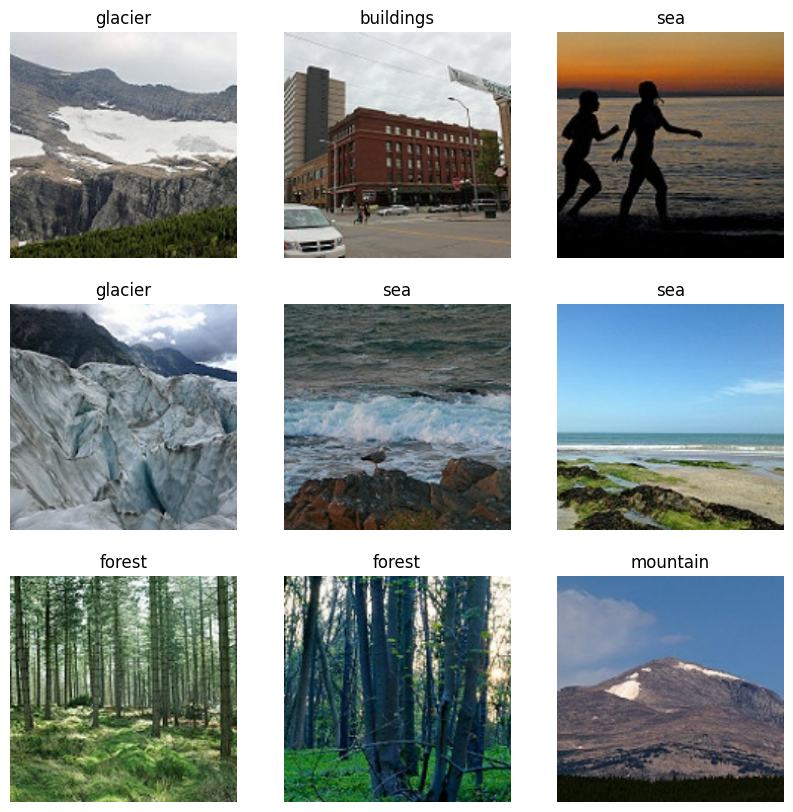

In [ ]:
# Muestra algunas imágenes de ejemplo
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_idx = list(labels[i]).index(1)
    plt.title(class_names[class_idx])
    plt.axis("off")

## Modelo con Capas Densas

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense

def dense_net(input_shape, num_classes):
    # Definir la entrada
    inputs = Input(shape=input_shape)

    # Aplicar Flatten a la entrada
    x = Flatten()(inputs)

    # Capas densas
    x = Dense(250, activation='relu')(x)
    x = Dense(250, activation='relu')(x)
    x = Dense(250, activation = 'sigmoid')(x)

    # Capa de salida
    outputs = Dense(num_classes, activation='softmax')(x)

    # Crear el modelo
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model


In [ ]:
input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)
num_classes = 6
model_dense_net = dense_net(input_shape, num_classes)

model_dense_net.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 150528)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 250)                 │      37,632,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 250)                 │          62,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 250)                 │          62,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │           1,506 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,759,256 (144.04 MB)

 Trainable params: 37,759,256 (144.04 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_dense_net.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_dense_net = model_dense_net.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping]
)

Epoch 1/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - accuracy: 0.1731 - loss: 1.8336 - val_accuracy: 0.1843 - val_loss: 1.7896
Epoch 2/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 15s 124ms/step - accuracy: 0.1674 - loss: 1.7946 - val_accuracy: 0.1750 - val_loss: 1.7930
Epoch 3/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 15s 124ms/step - accuracy: 0.1723 - loss: 1.7958 - val_accuracy: 0.1750 - val_loss: 1.7941
Epoch 4/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 14s 121ms/step - accuracy: 0.1718 - loss: 1.7946 - val_accuracy: 0.1750 - val_loss: 1.8008
Epoch 5/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.1739 - loss: 1.7926 - val_accuracy: 0.1750 - val_loss: 1.7912
Epoch 6/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 14s 118ms/step - accuracy: 0.1718 - loss: 1.7946 - val_accuracy: 0.1750 - val_loss: 1.8005


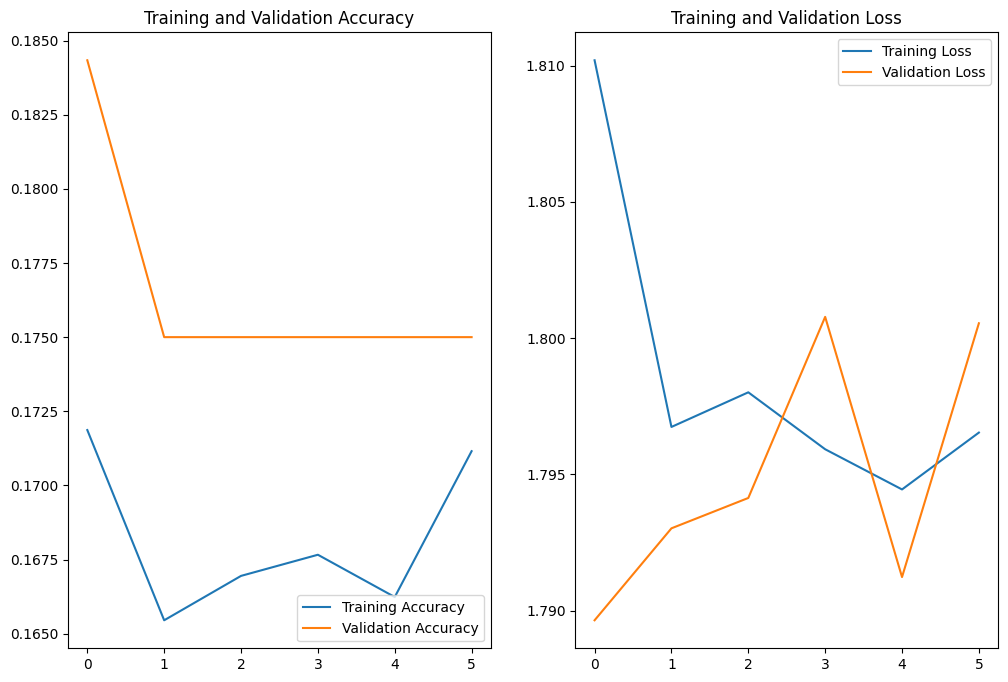

In [ ]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history_dense_net.history['accuracy']
val_acc = history_dense_net.history['val_accuracy']

loss = history_dense_net.history['loss']
val_loss = history_dense_net.history['val_loss']

epochs_range = range(len(val_loss))

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


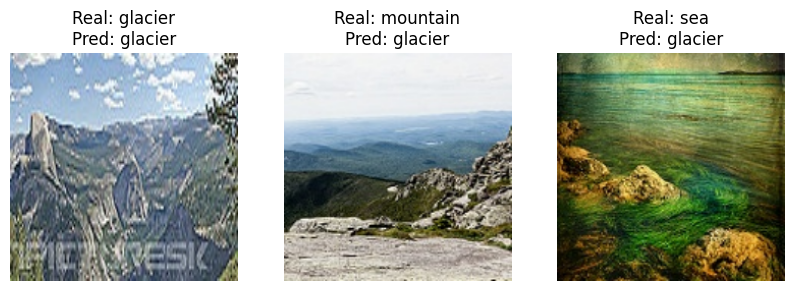

In [ ]:
# Selecciona tres lotes aleatorios del conjunto de validación
for images, labels in val_ds.take(1):
    # Selecciona tres índices aleatorios
    random_indices = random.sample(range(len(images)), 3)

    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(random_indices):
        # Obtén la imagen y la etiqueta
        image = images[idx].numpy().astype("uint8")
        true_label = class_names[list(labels[idx]).index(1)]

        # Realiza la predicción
        prediction = model_dense_net.predict(tf.expand_dims(images[idx], axis=0))
        predicted_label = class_names[np.argmax(prediction)]

        # Muestra la imagen
        ax = plt.subplot(1, 3, i + 1)
        plt.imshow(image)
        plt.title(f"Real: {true_label}\nPred: {predicted_label}")
        plt.axis("off")

    plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


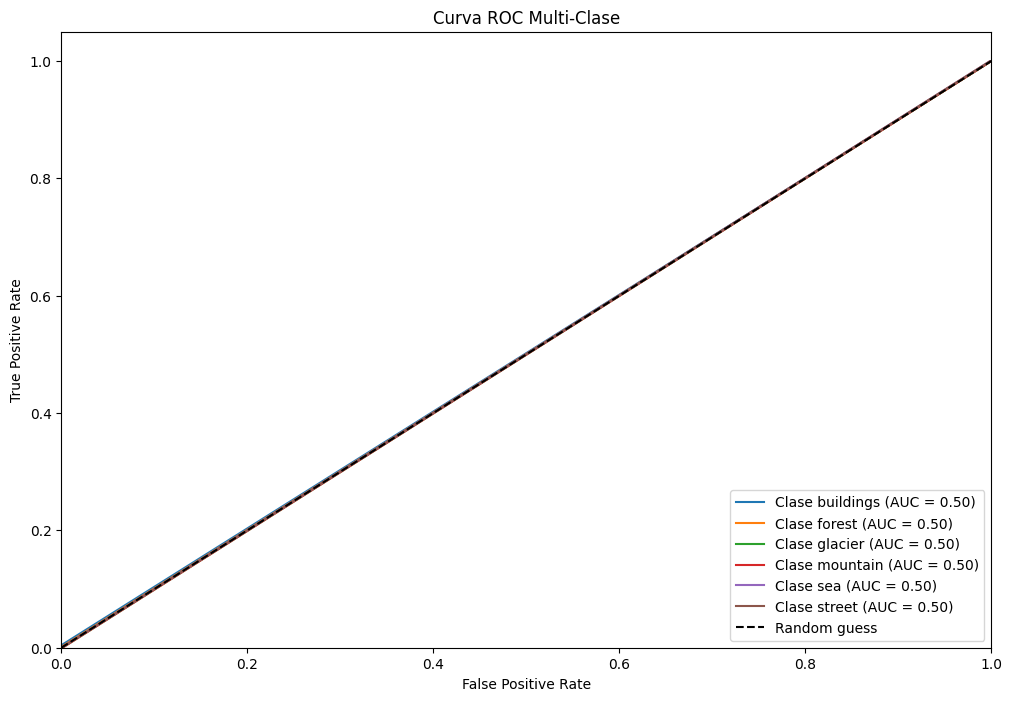

In [ ]:

# Convertir las etiquetas reales a formato binarizado (one-hot encoding)
true_labels = []
predictions = []

# Recorremos todo el conjunto de validación para obtener las predicciones y etiquetas verdaderas
for images, labels in val_ds:
    # Obtén las predicciones
    preds = model_dense_net.predict(images)
    predictions.append(preds)
    true_labels.append(labels)

# Convertimos las listas en arrays
true_labels = np.vstack(true_labels)
predictions = np.vstack(predictions)

# Graficar la curva ROC para cada clase
plt.figure(figsize=(12, 8))

for i in range(num_classes):
    # Calcular la curva ROC y el AUC para cada clase
    fpr, tpr, _ = roc_curve(true_labels[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)

    # Graficar la curva ROC
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC Multi-Clase')
plt.legend(loc="lower right")
plt.show()

## Modelo con Capas Convolucionales y Densas

In [ ]:
def conv_net(input_shape, num_classes):
    # Definir la entrada
    inputs = Input(shape=input_shape)
    x = Rescaling(1./255)(inputs)
    # Capas convolucionales
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
    x = Activation("relu")(x)

    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D(pool_size = (2,2))(x)

    x = Conv2D(32 ,(3, 3), activation='relu', padding='same')(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x) #Aplanar
    x = Dropout(0.2)(x)
    # Capas densas
    x = Dense(250, activation='relu')(x)
    x = Dense(250, activation='relu')(x)

    # Capa de salida
    outputs = Dense(num_classes, activation='softmax')(x)

    # Crear el modelo
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model


Version simplificada

In [ ]:
def conv_net_simplificado(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Rescaling(1./255)(inputs)

    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
input_shape = (224, 224, 3)
num_classes = 6
model_conv_net = conv_net_simplificado(input_shape, num_classes)

model_conv_net.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

model_conv_net.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 16)        │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,218,198 (12.28 MB)

 Trainable params: 3,218,198 (12.28 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)
num_classes = 6
model_conv_net = conv_net(input_shape, num_classes)

model_conv_net.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

model_conv_net.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 224, 224, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 16)        │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 56, 56, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 250)                 │       1,568,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 250)                 │          62,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 6)                   │           1,506 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,638,538 (6.25 MB)

 Trainable params: 1,638,538 (6.25 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Entrena el modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_conv_net = model_conv_net.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks = [early_stopping]
)

Epoch 1/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 32s 196ms/step - accuracy: 0.4797 - loss: 1.2826 - val_accuracy: 0.6970 - val_loss: 0.8389
Epoch 2/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - accuracy: 0.7246 - loss: 0.7411 - val_accuracy: 0.7323 - val_loss: 0.7158
Epoch 3/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.7897 - loss: 0.5767 - val_accuracy: 0.7683 - val_loss: 0.6314
Epoch 4/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step - accuracy: 0.8357 - loss: 0.4595 - val_accuracy: 0.7770 - val_loss: 0.6289
Epoch 5/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 19s 129ms/step - accuracy: 0.8727 - loss: 0.3734 - val_accuracy: 0.7437 - val_loss: 0.7523
Epoch 6/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - accuracy: 0.8893 - loss: 0.3082 - val_accuracy: 0.7583 - val_loss: 0.7335
Epoch 7/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - accuracy: 0.9116 - loss: 0.2494 - val_accuracy: 0.7847 - val_loss: 0.6974
Epoch 8/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 0.9236 - loss: 0

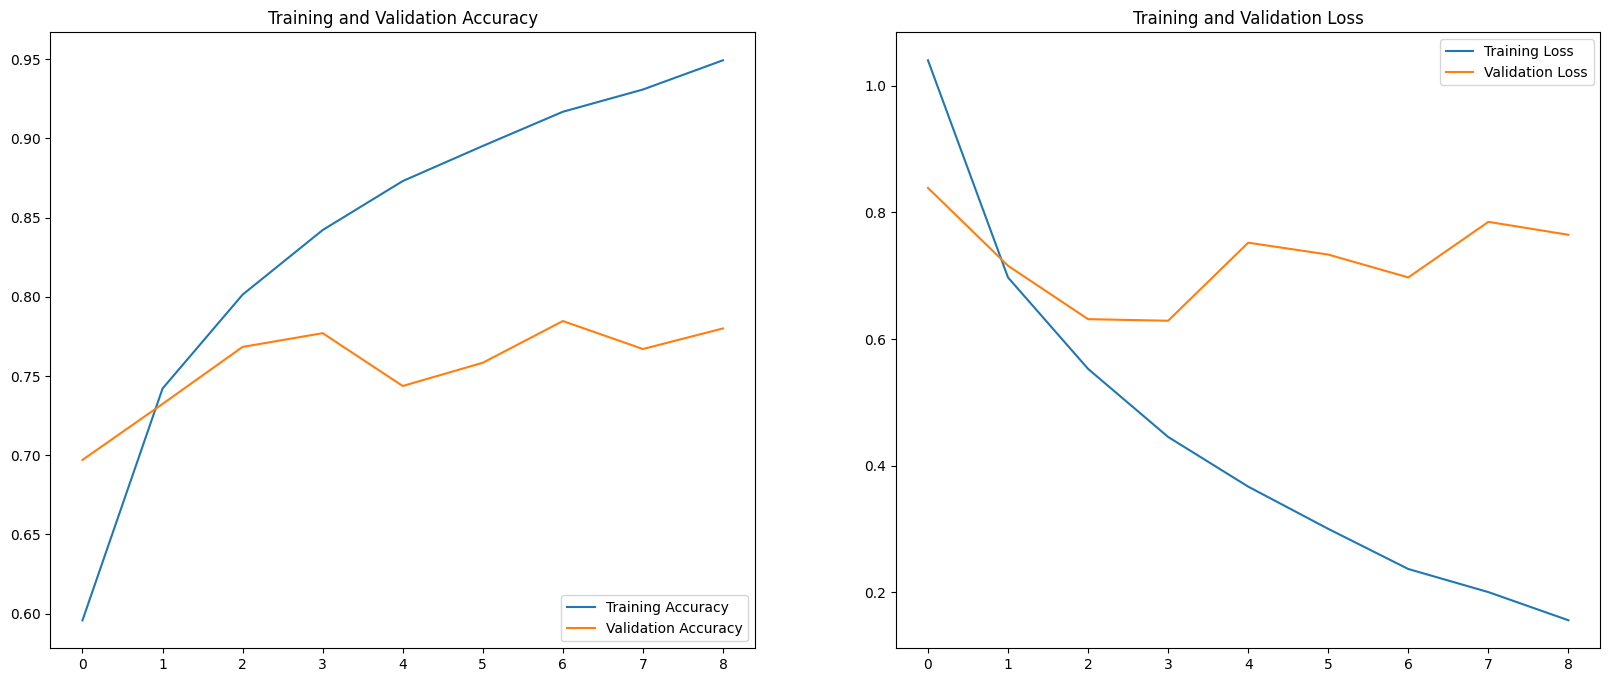

In [ ]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history_conv_net.history['accuracy']
val_acc = history_conv_net.history['val_accuracy']

loss = history_conv_net.history['loss']
val_loss = history_conv_net.history['val_loss']

epochs_range = range(len(val_loss))

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


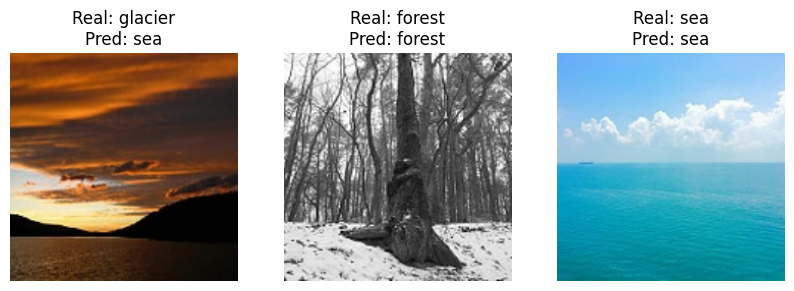

In [ ]:
# Selecciona tres lotes aleatorios del conjunto de validación
for images, labels in val_ds.take(1):
    # Selecciona tres índices aleatorios
    random_indices = random.sample(range(len(images)), 3)

    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(random_indices):
        # Obtén la imagen y la etiqueta
        image = images[idx].numpy().astype("uint8")
        true_label = class_names[list(labels[idx]).index(1)]

        # Realiza la predicción
        prediction = model_conv_net.predict(tf.expand_dims(images[idx], axis=0))
        predicted_label = class_names[np.argmax(prediction)]

        # Muestra la imagen
        ax = plt.subplot(1, 3, i + 1)
        plt.imshow(image)
        plt.title(f"Real: {true_label}\nPred: {predicted_label}")
        plt.axis("off")

    plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


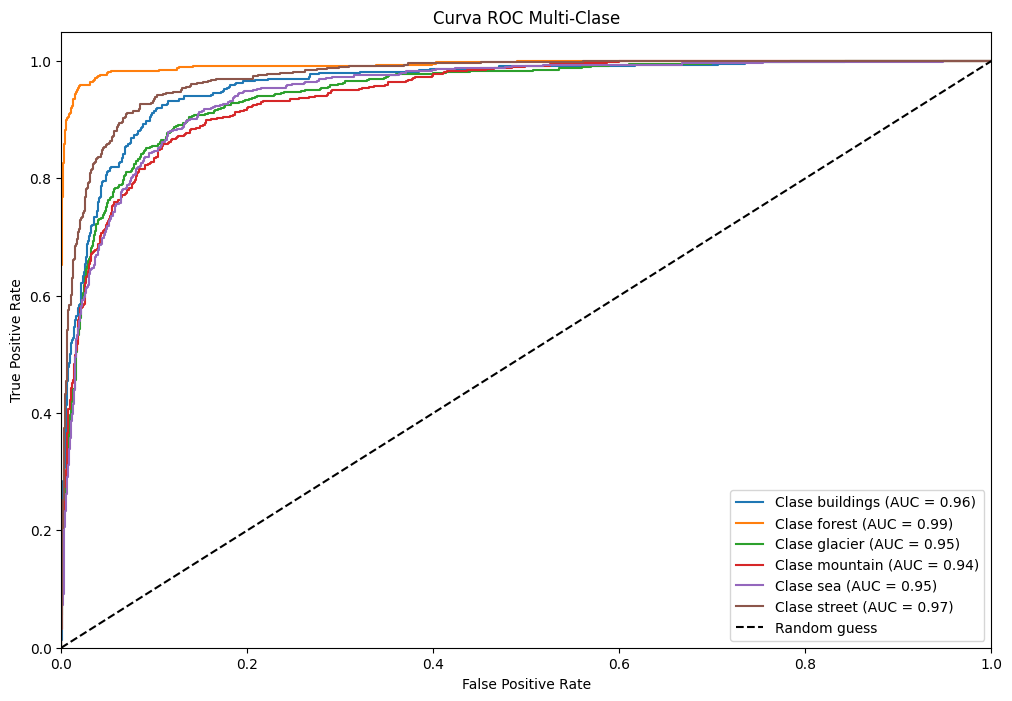

In [ ]:

# Convertir las etiquetas reales a formato binarizado (one-hot encoding)
true_labels = []
predictions = []

# Recorremos todo el conjunto de validación para obtener las predicciones y etiquetas verdaderas
for images, labels in val_ds:
    # Obtén las predicciones
    preds = model_conv_net.predict(images)
    predictions.append(preds)
    true_labels.append(labels)

# Convertimos las listas en arrays
true_labels = np.vstack(true_labels)
predictions = np.vstack(predictions)

# Graficar la curva ROC para cada clase
plt.figure(figsize=(12, 8))

for i in range(num_classes):
    # Calcular la curva ROC y el AUC para cada clase
    fpr, tpr, _ = roc_curve(true_labels[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)

    # Graficar la curva ROC
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC Multi-Clase')
plt.legend(loc="lower right")
plt.show()

## Modelo que Incluya bloques residuales de identidad

In [ ]:
def residual_block(x, filters, kernel_size=3, stride=1):
    # Shortcut (atajo)
    shortcut = x

    # Si el stride es mayor a 1 o los canales no coinciden, ajustamos el shortcut
    if stride != 1 or x.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Primera convolución
    x = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    # Segunda convolución
    x = Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Añadir el shortcut (proyectado o identidad)
    x = Add()([x, shortcut])
    x = Activation("relu")(x)

    return x


In [ ]:
def resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Rescaling(1./255)(inputs)
    # Capas convolucionales
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
    x = Activation("relu")(x)

    x = MaxPooling2D(pool_size=(3, 3))(x)

    x = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    x = Activation("relu")(x)

    x = MaxPooling2D(pool_size=(3, 3))(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = Activation("relu")(x)

    x = MaxPooling2D(pool_size=(3, 3))(x)

    # Bloques residuales
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)

    # Añadir más bloques residuales según la profundidad deseada
    x = residual_block(x, filters=128, stride=2)  # Reduce la dimensión
    x = residual_block(x, filters=128)

    # Capa de clasificación final
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(256, activation = 'relu')(x)
    x = Dense(256, activation = 'relu')(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    # Definir el modelo
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
model_resnet = resnet(input_shape, 6)
model_resnet.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

model_resnet.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 224, 224, 32)   │            896 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_5 (Activation) │ (None, 224, 224, 32)   │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 74, 74, 32)     │              0 │ activation_5[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 74, 74, 64)     │         18,496 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 74, 74, 64)     │            256 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_6 (Activation) │ (None, 74, 74, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 74, 74, 64)     │         36,928 │ activation_6[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 74, 74, 64)     │          2,112 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 74, 74, 64)     │            256 │ conv2d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 74, 74, 64)     │            256 │ conv2d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 74, 74, 64)     │              0 │ batch_normalization_2… │
│                           │                        │                │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_7 (Activation) │ (None, 74, 74, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 74, 74, 64)     │         36,928 │ activation_7[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 74, 74, 64)     │            256 │ conv2d_9[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_8 (Activation) │ (None, 74, 74, 64)     │              0 │ batch_normalization_3… │
├──────────────────────

 Total params: 827,206 (3.16 MB)

 Trainable params: 825,286 (3.15 MB)

 Non-trainable params: 1,920 (7.50 KB)

Modelo simplificado

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPooling2D, Dense, GlobalAveragePooling2D, Add, BatchNormalization, Rescaling
from tensorflow.keras.models import Model

# Bloque Residual
def residual_block(x, filters, stride=1):
    shortcut = x

    # Primera convolución
    x = Conv2D(filters, (3, 3), padding="same", strides=stride)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    # Segunda convolución
    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)

    # Atajo para igualar dimensiones
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), strides=stride)(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Adición y activación
    x = Add()([x, shortcut])
    x = Activation("relu")(x)
    return x

# Modelo ResNet
def resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Rescaling(1./255)(inputs)  # Normalización de los datos

    # Capas convolucionales iniciales
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Bloques residuales
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)

    x = residual_block(x, filters=128, stride=2)
    x = residual_block(x, filters=128)

    x = residual_block(x, filters=256, stride=2)
    x = residual_block(x, filters=256)

    # Clasificación
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    return model

model_resnet = resnet(input_shape, 6)
model_resnet.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

model_resnet.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_35 (Conv2D)        │ (None, 224, 224, 32)   │            896 │ rescaling_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 112, 112, 32)   │              0 │ conv2d_35[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_36 (Conv2D)        │ (None, 112, 112, 64)   │         18,496 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_30    │ (None, 112, 112, 64)   │            256 │ conv2d_36[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_24             │ (None, 112, 112, 64)   │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_37 (Conv2D)        │ (None, 112, 112, 64)   │         36,928 │ activation_24[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_38 (Conv2D)        │ (None, 112, 112, 64)   │          2,112 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_31    │ (None, 112, 112, 64)   │            256 │ conv2d_37[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_32    │ (None, 112, 112, 64)   │            256 │ conv2d_38[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_12 (Add)              │ (None, 112, 112, 64)   │              0 │ batch_normalization_3… │
│                           │                        │                │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_25             │ (None, 112, 112, 64)   │              0 │ add_12[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_39 (Conv2D)        │ (None, 112, 112, 64)   │         36,928 │ activation_25[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_33    │ (None, 112, 112, 64)   │            256 │ conv2d_39[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 2,831,942 (10.80 MB)

 Trainable params: 2,827,462 (10.79 MB)

 Non-trainable params: 4,480 (17.50 KB)

In [ ]:
# Entrena el modelo
history_resnet = model_resnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks = [early_stopping]
)

Epoch 1/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.5481 - loss: 1.1512 - val_accuracy: 0.1710 - val_loss: 3.7310
Epoch 2/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 115s 967ms/step - accuracy: 0.7504 - loss: 0.6562 - val_accuracy: 0.2283 - val_loss: 3.7983
Epoch 3/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 116s 995ms/step - accuracy: 0.7947 - loss: 0.5556 - val_accuracy: 0.4497 - val_loss: 2.3086
Epoch 4/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 117s 995ms/step - accuracy: 0.8190 - loss: 0.4751 - val_accuracy: 0.7237 - val_loss: 0.9960
Epoch 5/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 114s 970ms/step - accuracy: 0.8354 - loss: 0.4366 - val_accuracy: 0.6673 - val_loss: 1.1105


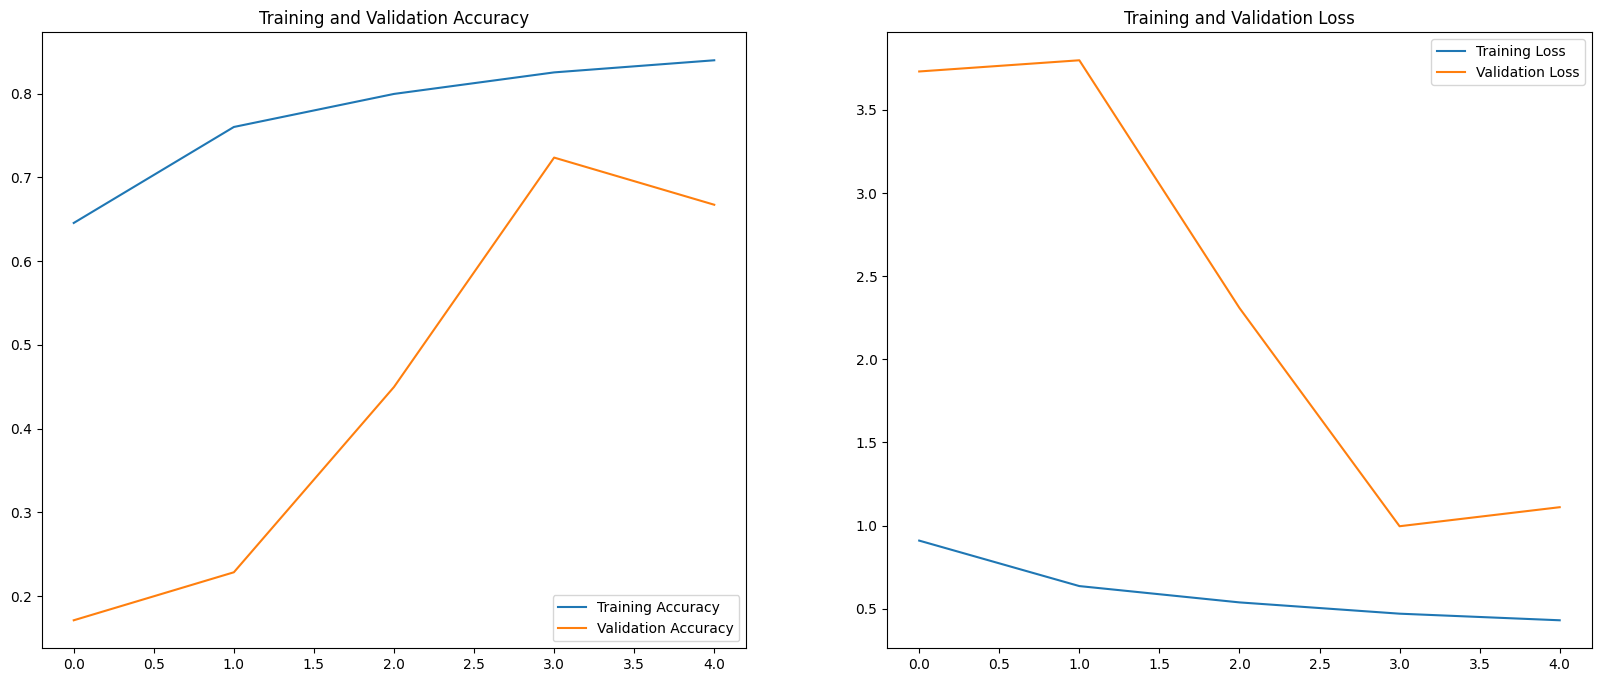

In [ ]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history_resnet.history['accuracy']
val_acc = history_resnet.history['val_accuracy']

loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']

epochs_range = range(len(val_loss))

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


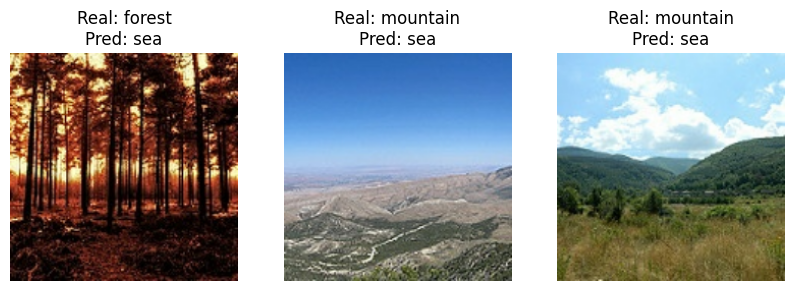

In [ ]:
# Selecciona tres lotes aleatorios del conjunto de validación
for images, labels in val_ds.take(1):
    # Selecciona tres índices aleatorios
    random_indices = random.sample(range(len(images)), 3)

    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(random_indices):
        # Obtén la imagen y la etiqueta
        image = images[idx].numpy().astype("uint8")
        true_label = class_names[list(labels[idx]).index(1)]

        # Realiza la predicción
        prediction = model_resnet.predict(tf.expand_dims(images[idx], axis=0))
        predicted_label = class_names[np.argmax(prediction)]

        # Muestra la imagen
        ax = plt.subplot(1, 3, i + 1)
        plt.imshow(image)
        plt.title(f"Real: {true_label}\nPred: {predicted_label}")
        plt.axis("off")

    plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


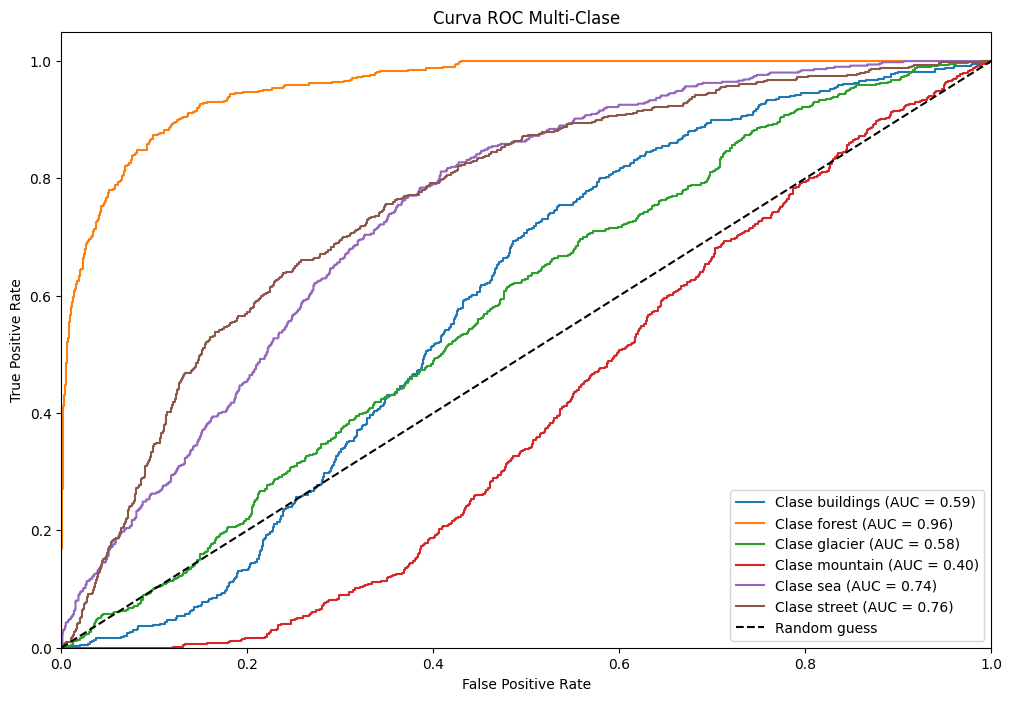

In [ ]:

# Convertir las etiquetas reales a formato binarizado (one-hot encoding)
true_labels = []
predictions = []

# Recorremos todo el conjunto de validación para obtener las predicciones y etiquetas verdaderas
for images, labels in val_ds:
    # Obtén las predicciones
    preds = model_resnet.predict(images)
    predictions.append(preds)
    true_labels.append(labels)

# Convertimos las listas en arrays
true_labels = np.vstack(true_labels)
predictions = np.vstack(predictions)

# Graficar la curva ROC para cada clase
plt.figure(figsize=(12, 8))

for i in range(num_classes):
    # Calcular la curva ROC y el AUC para cada clase
    fpr, tpr, _ = roc_curve(true_labels[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)

    # Graficar la curva ROC
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC Multi-Clase')
plt.legend(loc="lower right")
plt.show()

## Modelo con BackBone

In [39]:
def backbone(input_shape, num_classes):
    base_model = tf.keras.applications.resnet50.ResNet50(input_shape=input_shape,
                                                include_top=False,
                                                weights='imagenet')
    base_model.trainable = False

    i = Input(shape=input_shape)
    x = base_model(i, training=False)
    x = GlobalMaxPooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    return tf.keras.Model(i, x)


In [40]:
model_backbone = backbone(input_shape, num_classes)

In [ ]:
# Compila el modelo con backbone
model_backbone.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_backbone = model_backbone.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks = [early_stopping]
)


Epoch 1/20


In [ ]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history_backbone.history['accuracy']
val_acc = history_backbone.history['val_accuracy']

loss = history_backbone.history['loss']
val_loss = history_backbone.history['val_loss']

epochs_range = range(len(val_loss))

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


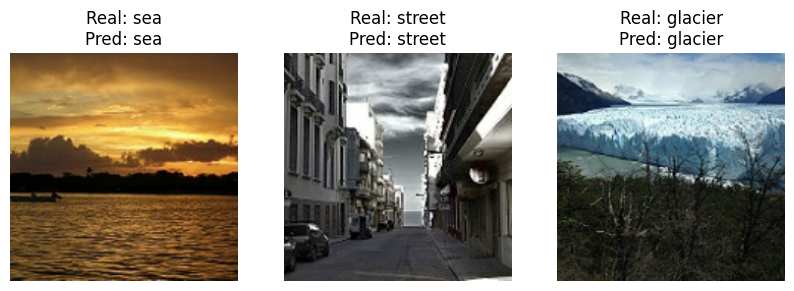

In [37]:
# Selecciona tres lotes aleatorios del conjunto de validación
for images, labels in val_ds.take(1):
    # Selecciona tres índices aleatorios
    random_indices = random.sample(range(len(images)), 3)

    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(random_indices):
        # Obtén la imagen y la etiqueta
        image = images[idx].numpy().astype("uint8")
        true_label = class_names[list(labels[idx]).index(1)]

        # Realiza la predicción
        prediction = model_backbone.predict(tf.expand_dims(images[idx], axis=0))
        predicted_label = class_names[np.argmax(prediction)]

        # Muestra la imagen
        ax = plt.subplot(1, 3, i + 1)
        plt.imshow(image)
        plt.title(f"Real: {true_label}\nPred: {predicted_label}")
        plt.axis("off")

    plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


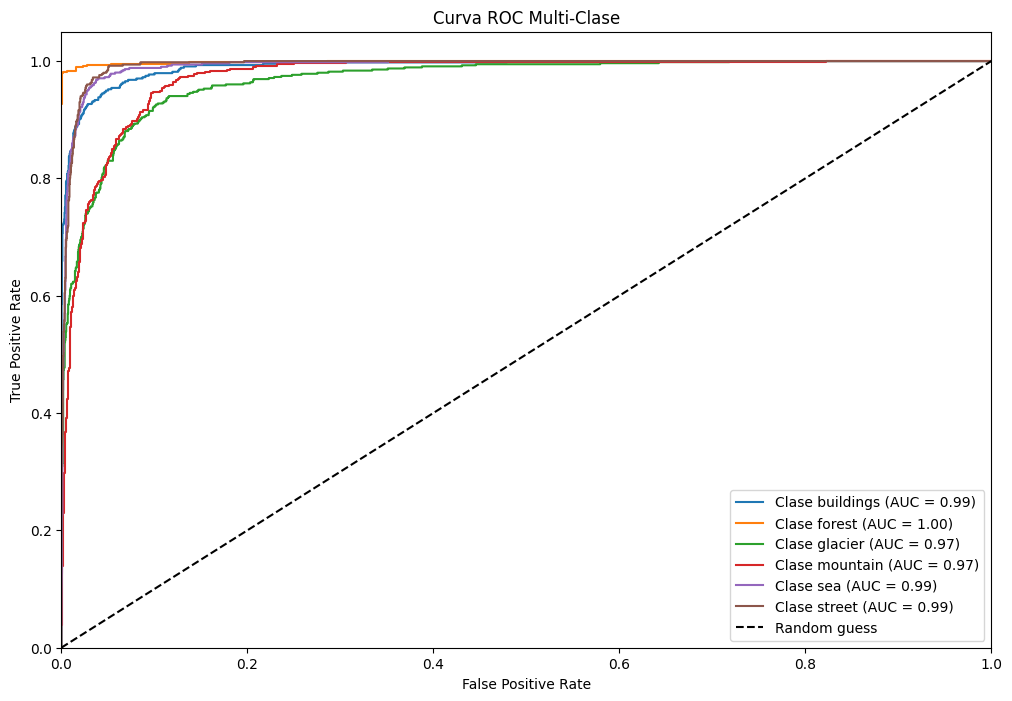

In [38]:

# Convertir las etiquetas reales a formato binarizado (one-hot encoding)
true_labels = []
predictions = []

# Recorremos todo el conjunto de validación para obtener las predicciones y etiquetas verdaderas
for images, labels in val_ds:
    # Obtén las predicciones
    preds = model_backbone.predict(images)
    predictions.append(preds)
    true_labels.append(labels)

# Convertimos las listas en arrays
true_labels = np.vstack(true_labels)
predictions = np.vstack(predictions)

# Graficar la curva ROC para cada clase
plt.figure(figsize=(12, 8))

for i in range(num_classes):
    # Calcular la curva ROC y el AUC para cada clase
    fpr, tpr, _ = roc_curve(true_labels[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)

    # Graficar la curva ROC
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC Multi-Clase')
plt.legend(loc="lower right")
plt.show()